In [32]:
!python -m pip install torch torchvision onnx onnxruntime onnxscript


[notice] A new release of pip available: 22.3 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

ssl._create_default_https_context = ssl._create_unverified_context

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisation des images
])

In [36]:
# Charger les données d'entraînement
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)


Files already downloaded and verified


In [37]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [38]:
classes = ('avion', 'automobile', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')


In [39]:
import matplotlib.pyplot as plt
import numpy as np


In [40]:
def imshow(img):
    img = img / 2 + 0.5  # Dé-normalisation des images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [41]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

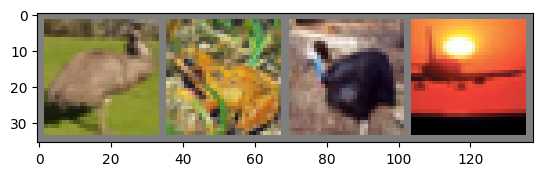

Labels : oiseau grenouille oiseau avion


In [42]:
imshow(torchvision.utils.make_grid(images))
print('Labels :', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Convolution 1
        self.pool = nn.MaxPool2d(2, 2)  # Pooling
        self.conv2 = nn.Conv2d(6, 16, 5)  # Convolution 2
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Fully Connected Layer 1
        self.fc2 = nn.Linear(120, 84)  # Fully Connected Layer 2
        self.fc3 = nn.Linear(84, 10)  # Fully Connected Layer 3

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [44]:
# Affichage de l'architecture du modèle cifar
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [45]:
criterion = nn.CrossEntropyLoss()  # Fonction de perte
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # Optimiseur


In [46]:
for epoch in range(2):  # Nombre d'époques
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Obtenir les entrées et les labels
        inputs, labels = data[0].to(device), data[1].to(device)

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Propagation avant, perte, rétropropagation et optimisation
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Afficher les statistiques
        running_loss += loss.item()
        if i % 2000 == 1999:  # Affichage tous les 2000 mini-batches
            print(f'[Epoch {epoch + 1}, Mini-batch {i + 1}] Loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Entraînement terminé')

[Epoch 1, Mini-batch 2000] Loss: 2.183
[Epoch 1, Mini-batch 4000] Loss: 1.809
[Epoch 1, Mini-batch 6000] Loss: 1.684
[Epoch 1, Mini-batch 8000] Loss: 1.583
[Epoch 1, Mini-batch 10000] Loss: 1.533
[Epoch 1, Mini-batch 12000] Loss: 1.464
[Epoch 2, Mini-batch 2000] Loss: 1.398
[Epoch 2, Mini-batch 4000] Loss: 1.376
[Epoch 2, Mini-batch 6000] Loss: 1.348
[Epoch 2, Mini-batch 8000] Loss: 1.315
[Epoch 2, Mini-batch 10000] Loss: 1.292
[Epoch 2, Mini-batch 12000] Loss: 1.266
Entraînement terminé


On observe ici que le modèle fait beaucoup plus d'erreurs au début qu'a la fin donc le modèle apprend mais à la fin ça stagne 

In [47]:
correct = 0
total = 0

In [48]:
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)  # Prédictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [49]:
print(f'Précision du réseau sur les 10 000 images de test : {100 * correct / total:.2f}%')


Précision du réseau sur les 10 000 images de test : 54.63%


Je vais essayer d'améliorer la précision du modèle :

In [51]:
# 1. Modifier l'architecture du modèle avec Batch Normalization, Dropout et plus de couches
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = ImprovedNet().to(device)
print(net)

ImprovedNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [53]:
# 2. Appliquer l'augmentation des données
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [54]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)


Files already downloaded and verified


In [55]:
# 3. Utiliser un optimiseur différent comme Adam
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [57]:
# 4. Augmenter le nombre d'époques
for epoch in range(4):  # Augmente à 4 époques
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[Epoch {epoch + 1}, Mini-batch {i + 1}] Loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Entraînement terminé avec les améliorations')

[Epoch 1, Mini-batch 2000] Loss: 1.216
[Epoch 1, Mini-batch 4000] Loss: 1.217
[Epoch 1, Mini-batch 6000] Loss: 1.213
[Epoch 1, Mini-batch 8000] Loss: 1.200
[Epoch 1, Mini-batch 10000] Loss: 1.192
[Epoch 1, Mini-batch 12000] Loss: 1.188
[Epoch 2, Mini-batch 2000] Loss: 1.139
[Epoch 2, Mini-batch 4000] Loss: 1.159
[Epoch 2, Mini-batch 6000] Loss: 1.153
[Epoch 2, Mini-batch 8000] Loss: 1.124
[Epoch 2, Mini-batch 10000] Loss: 1.130
[Epoch 2, Mini-batch 12000] Loss: 1.145
[Epoch 3, Mini-batch 2000] Loss: 1.109
[Epoch 3, Mini-batch 4000] Loss: 1.095
[Epoch 3, Mini-batch 6000] Loss: 1.109
[Epoch 3, Mini-batch 8000] Loss: 1.099
[Epoch 3, Mini-batch 10000] Loss: 1.103
[Epoch 3, Mini-batch 12000] Loss: 1.090
[Epoch 4, Mini-batch 2000] Loss: 1.056
[Epoch 4, Mini-batch 4000] Loss: 1.055
[Epoch 4, Mini-batch 6000] Loss: 1.057
[Epoch 4, Mini-batch 8000] Loss: 1.069
[Epoch 4, Mini-batch 10000] Loss: 1.071
[Epoch 4, Mini-batch 12000] Loss: 1.084
Entraînement terminé avec les améliorations


In [58]:
# 5. J'évalue à nouveau le modèle avec les améliorations
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Précision améliorée sur les 10 000 images de test : {100 * correct / total:.2f}%')


Précision améliorée sur les 10 000 images de test : 63.51%


In [59]:
# Étape 7 : Exporter le modèle en ONNX
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Exemple d'entrée avec la même taille que CIFAR-10
onnx_file_path = "improved_net.onnx"

# Exporter le modèle
torch.onnx.export(net, dummy_input, onnx_file_path, export_params=True,
                  opset_version=11, do_constant_folding=True,
                  input_names=['input'], output_names=['output'])

print(f"Modèle exporté en ONNX à l'emplacement : {onnx_file_path}")

Modèle exporté en ONNX à l'emplacement : improved_net.onnx


In [60]:
#Test 
import onnxruntime as ort
session = ort.InferenceSession(onnx_file_path)
example_input = dummy_input.cpu().numpy()
outputs = session.run(None, {"input": example_input})
predicted_class = np.argmax(outputs[0])
print(f"Classe prédite par le modèle ONNX : {classes[predicted_class]}")

Classe prédite par le modèle ONNX : chien
